# Notebook 6: Trying with last periodicity of 1,2

# Data

The data is downloaded from NATIONAL CENTRE FOR POLAR AND OCEAN RESEARCH, India: http://data.ncaor.gov.in/newhtml

# Dataset Info

In [1]:
with open('b_imdncpor_synoptic.txt') as f:
    print(' '.join(f.readlines()))


 ----------------------Synoptic Data-------------------------------------------------------------------
 
 Measurements/ data	: Synoptic
 Parameters		: Observation Time,  wind direction, wind speed, temparature, MSLP
 Duration		: 05-05-2016 to	02-08-2021
 Location		: Bharati
 Latitude and Longitude	: 69Â°24.41'S, 76Â°11.72'E
 Data file format	: ASCII
 
 ------------------------------------------------------------------------------------------------------
 
 
 



In [2]:
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('synoptic_bharati.csv')
df.Time = pd.to_datetime(df.Time)
df.head()

,Time,WindDirection,WindSpeed,Temperature,Pressure
0,2016-05-01 00:00:00,5,8.0,-21.5,981.1
1,2016-05-22 00:00:00,0,0.0,-19.4,986.1
2,2016-05-22 06:00:00,9,10.0,-16.6,980.4
3,2016-05-22 12:00:00,9,9.0,-17.4,973.4
4,2016-05-22 18:00:00,5,13.0,-17.4,970.7


In [4]:
min_time = df.Time.min()
max_time = df.Time.max()
weather_data = pd.DataFrame(pd.date_range(min_time,max_time, freq='6H'), columns=['Time'])
weather_data.head()

,Time
0,2016-05-01 00:00:00
1,2016-05-01 06:00:00
2,2016-05-01 12:00:00
3,2016-05-01 18:00:00
4,2016-05-02 00:00:00


https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html

In [5]:
weather_data = pd.merge(weather_data, df, on='Time', how='left')
weather_data.isna().sum()

Time                0
WindDirection    1906
WindSpeed        2013
Temperature      1922
Pressure         2268
dtype: int64

In [6]:
weather_data = weather_data.loc[2715:6000] # Through manual inspection and checking

Using Temperature data to forecast future temperature.

In [7]:
temp_df = weather_data[['Temperature']].copy()
temp_df.head()

,Temperature
2715,-14.6
2716,-17.2
2717,-14.0
2718,-15.5
2719,-16.8


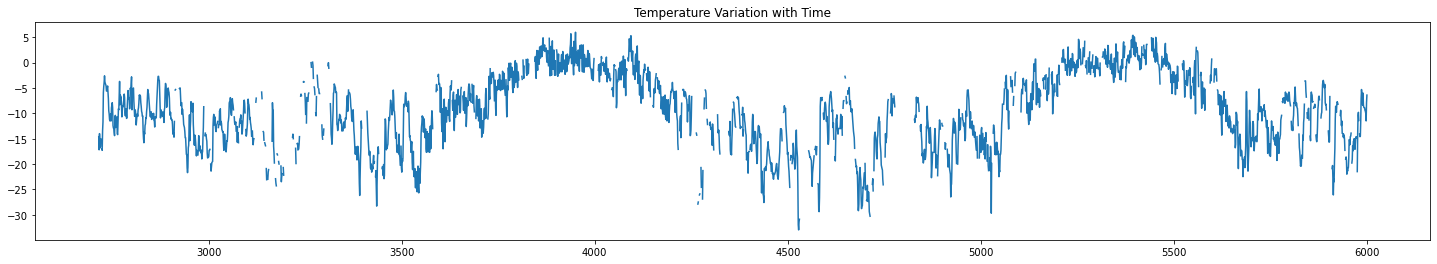

In [8]:
weather_data.Temperature.plot(figsize=(25,4), title='Temperature Variation with Time')
plt.show()

We can see highest temperature around january and lowet temperatures around July to October.

In [9]:
def simple_x_y_splitter(dataframe, col, prev_n_days=[]):
    df = dataframe.copy()
    for lag in prev_n_days:
        df[f'lag_{lag}'] = df[col].shift(lag)
    df.dropna(inplace=True)
    y = df[col].values
    X = df.drop([col], axis=1).values
    return np.expand_dims(X,2), y

In [10]:
X, y = simple_x_y_splitter(temp_df, 'Temperature',prev_n_days=[1,2])

In [11]:
y

array([-14. , -15.5, -16.8, ..., -11.5,  -7.9,  -6.4])

In [12]:
X

array([[[-17.2],
        [-14.6]],

       [[-14. ],
        [-17.2]],

       [[-15.5],
        [-14. ]],

       ...,

       [[-10. ],
        [ -9.6]],

       [[-11.5],
        [-10. ]],

       [[ -7.9],
        [-11.5]]])

In [13]:
y.shape

(2259,)

# Temporal splitting

In [14]:
train_val_split_idx, val_test_split_idx = int(X.shape[0]*.7), int(X.shape[0]*.85)
print(train_val_split_idx, val_test_split_idx)
X_train, y_train = X[:train_val_split_idx], y[:train_val_split_idx]
X_val, y_val = X[train_val_split_idx:val_test_split_idx], y[train_val_split_idx:val_test_split_idx]
X_test, y_test = X[val_test_split_idx:], y[val_test_split_idx:]

1581 1920


# Standardization

In [15]:
X_train_mean = X_train.mean()
X_train_sd= X_train.std()
y_train_mean = y_train.mean()
y_train_sd= y_train.std()

def standardize(x, y):
    x_std = (x-X_train_mean)/X_train_sd
    y_std = (y-y_train_mean)/y_train_sd
    return x_std, y_std

X_train_std, y_train_std = standardize(X_train, y_train)
X_val_std, y_val_std = standardize(X_val, y_val)
X_test_std, y_test_std = standardize(X_test, y_test)

# LSTM Model 1

In [16]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError

In [17]:
from tensorflow.keras.callbacks import TensorBoard

tb1 = TensorBoard(
    log_dir='logs5',
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq='epoch',
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None
)

In [21]:
model1 = Sequential()
model1.add(InputLayer((2,1)))
model1.add(LSTM(64))
model1.add(Dense(8,'relu'))
model1.add(Dense(1,'linear'))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 8)                 520       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [22]:
cp1 = ModelCheckpoint('model5/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [23]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[cp1, tb1])

Epoch 1/50
42/50 [========================>.....] - ETA: 0s - loss: 151.2448 - root_mean_squared_error: 12.2982

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 24s 324ms/step - loss: 150.0052 - root_mean_squared_error: 12.2477 - val_loss: 32.5132 - val_root_mean_squared_error: 5.7020
Epoch 2/50
49/50 [============================>.] - ETA: 0s - loss: 108.3194 - root_mean_squared_error: 10.4077

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 17s 356ms/step - loss: 108.1705 - root_mean_squared_error: 10.4005 - val_loss: 18.6316 - val_root_mean_squared_error: 4.3164
Epoch 3/50
47/50 [===========================>..] - ETA: 0s - loss: 54.8836 - root_mean_squared_error: 7.4083

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 15s 314ms/step - loss: 53.8029 - root_mean_squared_error: 7.3350 - val_loss: 12.4045 - val_root_mean_squared_error: 3.5220
Epoch 4/50
42/50 [========================>.....] - ETA: 0s - loss: 27.8632 - root_mean_squared_error: 5.2786

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 23s 460ms/step - loss: 27.1763 - root_mean_squared_error: 5.2131 - val_loss: 9.1045 - val_root_mean_squared_error: 3.0174
Epoch 5/50
48/50 [===========================>..] - ETA: 0s - loss: 17.1738 - root_mean_squared_error: 4.1441

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 45s 914ms/step - loss: 17.1758 - root_mean_squared_error: 4.1444 - val_loss: 6.9642 - val_root_mean_squared_error: 2.6390
Epoch 6/50
44/50 [=========================>....] - ETA: 0s - loss: 12.0699 - root_mean_squared_error: 3.4742

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 23s 462ms/step - loss: 12.0803 - root_mean_squared_error: 3.4757 - val_loss: 6.2262 - val_root_mean_squared_error: 2.4952
Epoch 7/50
44/50 [=========================>....] - ETA: 0s - loss: 9.3946 - root_mean_squared_error: 3.0651

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 23s 466ms/step - loss: 9.5672 - root_mean_squared_error: 3.0931 - val_loss: 5.8718 - val_root_mean_squared_error: 2.4232
Epoch 8/50
47/50 [===========================>..] - ETA: 0s - loss: 8.1467 - root_mean_squared_error: 2.8542

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 25s 510ms/step - loss: 8.2242 - root_mean_squared_error: 2.8678 - val_loss: 5.5619 - val_root_mean_squared_error: 2.3584
Epoch 9/50
46/50 [==========================>...] - ETA: 0s - loss: 7.3220 - root_mean_squared_error: 2.7059

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 15s 296ms/step - loss: 7.2371 - root_mean_squared_error: 2.6902 - val_loss: 5.3261 - val_root_mean_squared_error: 2.3078
Epoch 10/50
42/50 [========================>.....] - ETA: 0s - loss: 6.6130 - root_mean_squared_error: 2.5716

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 16s 331ms/step - loss: 6.5138 - root_mean_squared_error: 2.5522 - val_loss: 5.0298 - val_root_mean_squared_error: 2.2427
Epoch 11/50
45/50 [==========================>...] - ETA: 0s - loss: 5.9641 - root_mean_squared_error: 2.4421

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 15s 303ms/step - loss: 5.9075 - root_mean_squared_error: 2.4305 - val_loss: 4.8673 - val_root_mean_squared_error: 2.2062
Epoch 12/50
47/50 [===========================>..] - ETA: 0s - loss: 5.4636 - root_mean_squared_error: 2.3374

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 19s 381ms/step - loss: 5.4501 - root_mean_squared_error: 2.3346 - val_loss: 4.7406 - val_root_mean_squared_error: 2.1773
Epoch 13/50
48/50 [===========================>..] - ETA: 0s - loss: 5.1459 - root_mean_squared_error: 2.2684

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 20s 409ms/step - loss: 5.1673 - root_mean_squared_error: 2.2732 - val_loss: 4.7147 - val_root_mean_squared_error: 2.1713
Epoch 14/50
50/50 [==============================] - 0s 10ms/step - loss: 5.0799 - root_mean_squared_error: 2.2539 - val_loss: 4.7422 - val_root_mean_squared_error: 2.1777
Epoch 15/50
50/50 [==============================] - ETA: 0s - loss: 4.9447 - root_mean_squared_error: 2.2237

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 16s 328ms/step - loss: 4.9447 - root_mean_squared_error: 2.2237 - val_loss: 4.6606 - val_root_mean_squared_error: 2.1589
Epoch 16/50
48/50 [===========================>..] - ETA: 0s - loss: 4.7814 - root_mean_squared_error: 2.1866

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 17s 350ms/step - loss: 4.8372 - root_mean_squared_error: 2.1994 - val_loss: 4.6432 - val_root_mean_squared_error: 2.1548
Epoch 17/50
50/50 [==============================] - 0s 9ms/step - loss: 4.6232 - root_mean_squared_error: 2.1502 - val_loss: 4.9123 - val_root_mean_squared_error: 2.2164
Epoch 18/50
50/50 [==============================] - 0s 9ms/step - loss: 4.5906 - root_mean_squared_error: 2.1426 - val_loss: 4.6471 - val_root_mean_squared_error: 2.1557
Epoch 19/50
50/50 [==============================] - 0s 9ms/step - loss: 4.5739 - root_mean_squared_error: 2.1387 - val_loss: 4.6862 - val_root_mean_squared_error: 2.1648
Epoch 20/50
45/50 [==========================>...] - ETA: 0s - loss: 4.4492 - root_mean_squared_error: 2.1093

INFO:tensorflow:Assets written to: model5\assets


INFO:tensorflow:Assets written to: model5\assets


50/50 [==============================] - 15s 296ms/step - loss: 4.4472 - root_mean_squared_error: 2.1088 - val_loss: 4.6420 - val_root_mean_squared_error: 2.1545
Epoch 21/50
50/50 [==============================] - 0s 8ms/step - loss: 4.4235 - root_mean_squared_error: 2.1032 - val_loss: 4.6822 - val_root_mean_squared_error: 2.1638
Epoch 22/50
50/50 [==============================] - 0s 9ms/step - loss: 4.4015 - root_mean_squared_error: 2.0980 - val_loss: 4.6923 - val_root_mean_squared_error: 2.1662
Epoch 23/50
50/50 [==============================] - 1s 12ms/step - loss: 4.3493 - root_mean_squared_error: 2.0855 - val_loss: 4.7014 - val_root_mean_squared_error: 2.1683
Epoch 24/50
50/50 [==============================] - 0s 9ms/step - loss: 4.4349 - root_mean_squared_error: 2.1059 - val_loss: 4.7537 - val_root_mean_squared_error: 2.1803
Epoch 25/50
50/50 [==============================] - 0s 9ms/step - loss: 4.3948 - root_mean_squared_error: 2.0964 - val_loss: 4.7125 - val_root_mean_squa

In [24]:
def post_process(y):
    return (X_train_sd*y)+X_train_mean

In [25]:
from tensorflow.keras.models import load_model
model1 = load_model('model5/')

In [26]:
predicted_test_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_test_std).flatten()), 'Actual Temperature': y_test})
predicted_val_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_val_std).flatten()), 'Actual Temperature': y_val})
predicted_train_df = pd.DataFrame({'Predicted Temperature':post_process(model1.predict(X_train_std).flatten()), 'Actual Temperature': y_train})

50/50 [==============================] - 0s 3ms/step


In [27]:
from sklearn.metrics import mean_squared_error

<AxesSubplot:title={'center':'RMSE: 2.797422791587077'}>

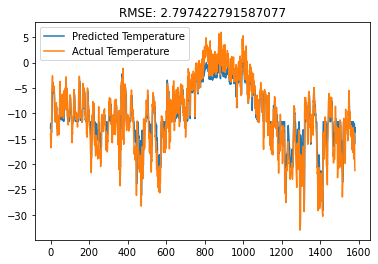

In [28]:
predicted_train_df.plot(title=f"RMSE: {mean_squared_error(predicted_train_df['Actual Temperature'], predicted_train_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.943526684534907'}>

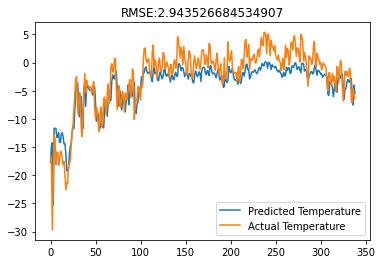

In [29]:
predicted_val_df.plot(title = f"RMSE:{mean_squared_error(predicted_val_df['Actual Temperature'], predicted_val_df['Predicted Temperature'], squared=False)}")

<AxesSubplot:title={'center':'RMSE:2.821039858704237'}>

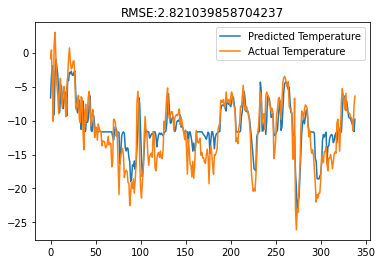

In [30]:
predicted_test_df.plot(title = f"RMSE:{mean_squared_error(predicted_test_df['Actual Temperature'], predicted_test_df['Predicted Temperature'], squared=False)}")


In [ ]:
y.shape

(1764,)